<a href="https://colab.research.google.com/github/els285/Aachen_Intro2NN/blob/ModelBuilding_Adjustments/DNN4HEP_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classifier for Particle Physics

In this exercise, we'll build a PyTorch binary classifier DNN, and apply this DNN to separating a Higgs Boson signal from a background process.

The signal process is a Higgs Boson decaying to two leptons among other stuff. The background process is a pair of top quarks decaying to a very similar final state, two leptons plus other particles, that look on a first glance essentially the same in the detector.

Each dataset contains 26 features related to the particles detected in each case.

In [2]:
import h5py
import pandas as pd
import numpy as np
import torch

## Importing Data

The first thing to do is to load your data. It is provided for you on CERNBox. You should be able to access it. If problems arise, contact one of the tutors.

So, to download the input data execute the next code block.

In [3]:
url = "https://cernbox.cern.ch/remote.php/dav/public-files/icjK5HWChdTcdb2/WW_vs_TT_dataset.h5"

import requests
import io

# download
response = requests.get(url)
response.raise_for_status() # Check for download errors

# load into a in-memory binary stream
H_vs_TT_dataset = io.BytesIO(response.content)


The data is stored in `h5` format which is the industry standard for storing numpy arrays in machine learning contexts.

The file contains two datasets, `Signal` and `Background`. Each dataset is an array of shape N x 26, where N is the number of separate proton-proton collisions (we call these "events") and 26 refers to the number of features stored in that file.

We can load both datasets as [pandas](https://pandas.pydata.org/docs/user_guide/index.html) dataframes.

In [4]:
# Load file
file = h5py.File(H_vs_TT_dataset, 'r')

# Extract data
df_signal       = pd.DataFrame(file['Signal'][:])
df_background   = pd.DataFrame(file['Background'][:])

## Data Visualisation

As we stated in the lectures, it's useful to understand the input parameters and compare them between the different classes to get a feeling for the actual task.

Remember you are supposed to design a classifier that

The following function can be used to draw histograms of a certain feature for the two classes in order to compare them.

In [5]:
import matplotlib.pyplot as plt
def compare_distributions(signal_data, background_data, variable_name):
    plt.figure(figsize=(10, 6),dpi=100)
    plt.hist(signal_data[variable_name], bins=40,  histtype='step', label='Signal', density=True)
    plt.hist(background_data[variable_name], bins=40, histtype='step', label='Background', density=True)
    plt.xlabel(variable_name)
    plt.ylabel('Density')
    plt.title(f'Distribution of {variable_name}')
    plt.legend()
    plt.show()

Just as an exaple let's have a look at one of the leptons' energy.

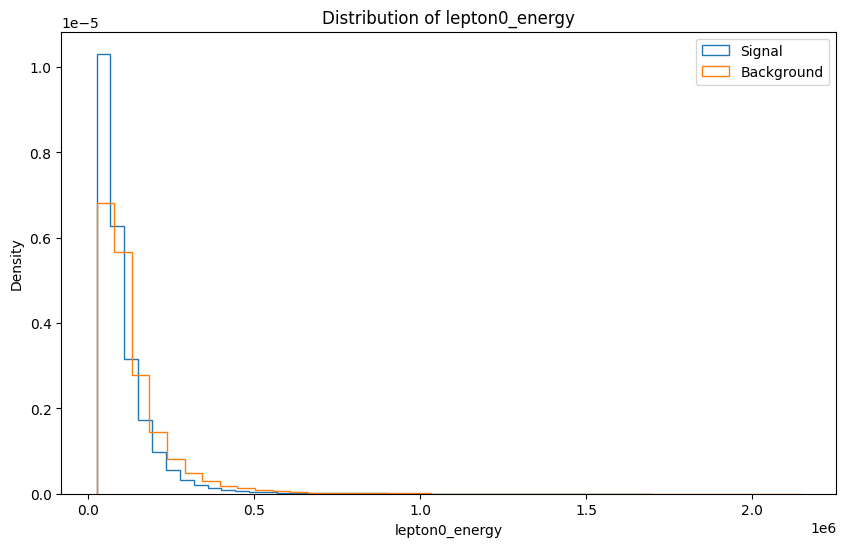

In [6]:
compare_distributions(df_signal, df_background, 'lepton0_energy')

#### Question!

Do you think with this information alone you could reliably distinguish between signal and background?

As you can see, there are some differences in the feature distributions comparing the two classes. But they aren't huge and overlap quite a bit. So a classifier using this would probably not suffice for anything practical. You have to include addiditonal information.

Here is a list of all the other features stored in the dataset:
```python
['lepton0_px', 'lepton0_py', 'lepton0_pz', 'lepton0_energy',
'lepton1_px', 'lepton1_py', 'lepton1_pz', 'lepton1_energy',
'jet0_px', 'jet0_py', 'jet0_pz', 'jet0_energy',
'jet1_px', 'jet1_py', 'jet1_pz', 'jet1_energy',
'Njets', 'HT_all', 'MissingEnergy',
'lepton0_mass', 'lepton1_mass', 'jet0_mass', 'jet1_mass', 'combined_leptons_mass',
'angle_between_jets', 'angle_between_leptons']
```
Try to plot some of them and pick the ones you think are suitable for separating the signal from background.

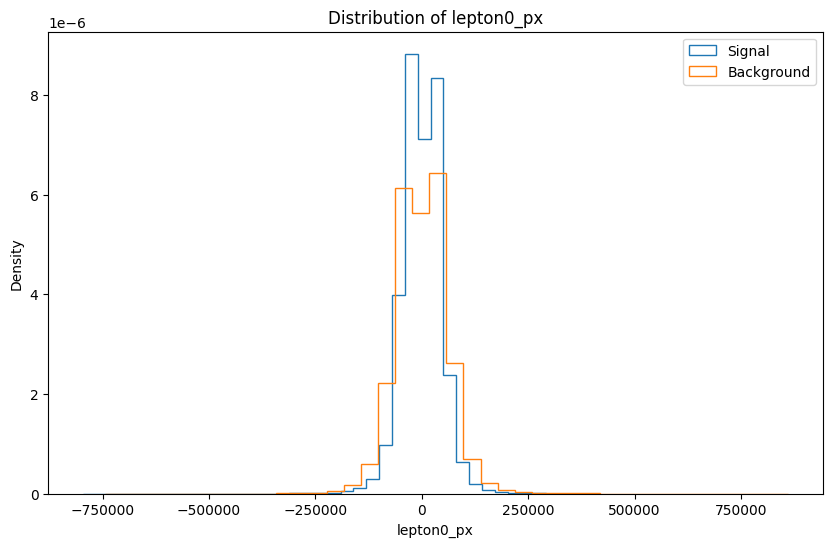

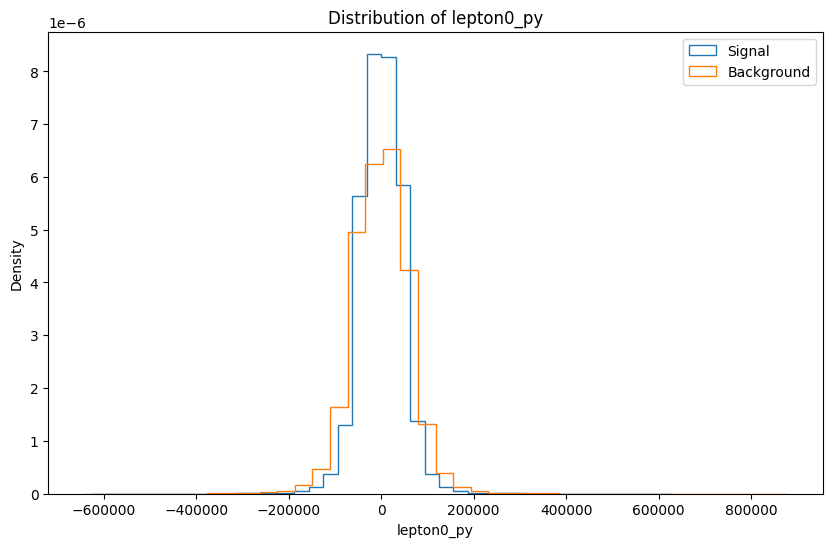

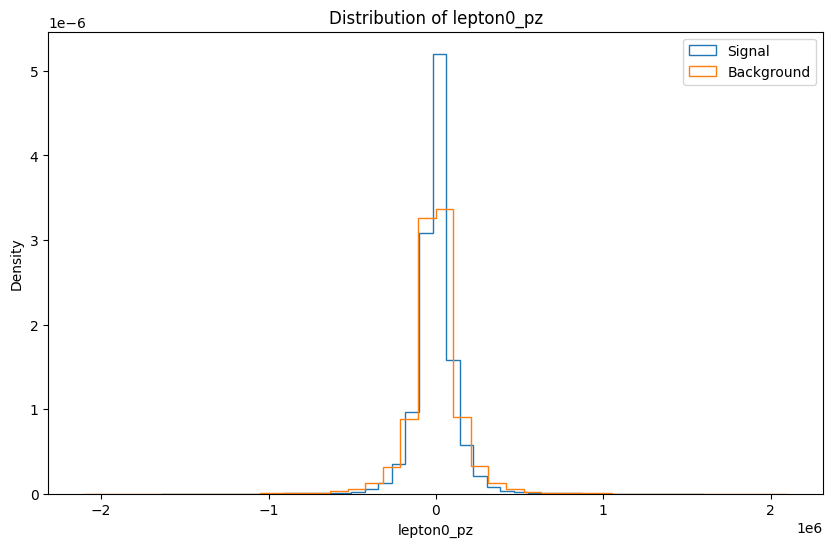

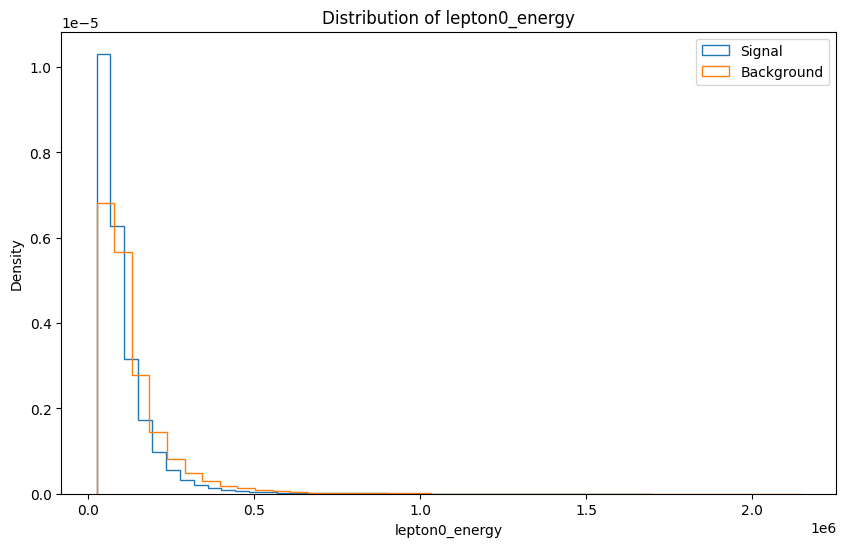

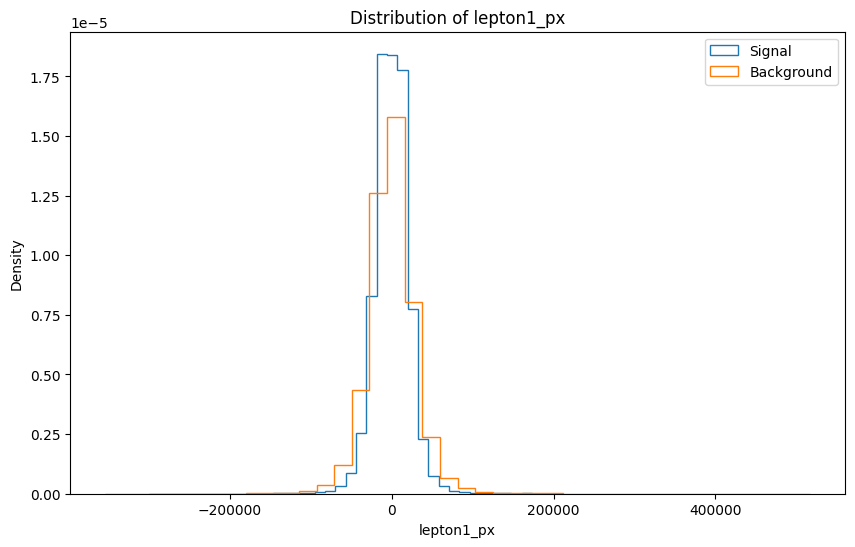

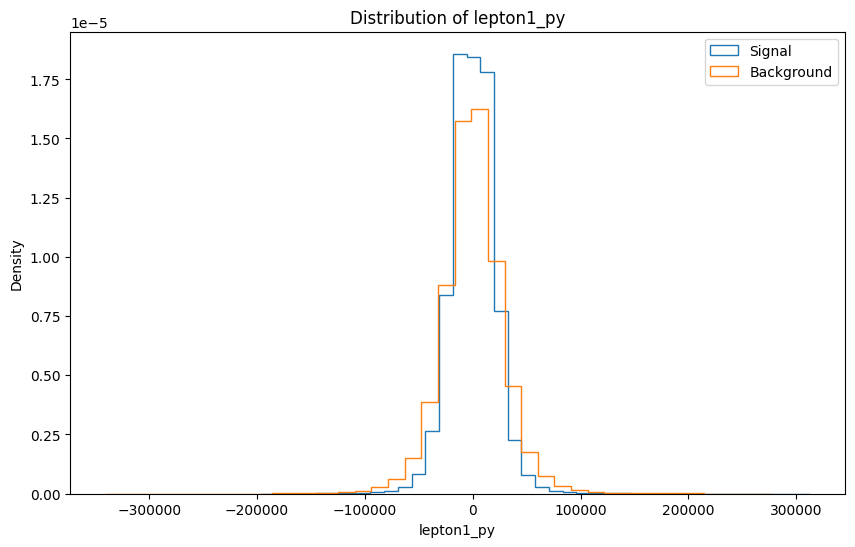

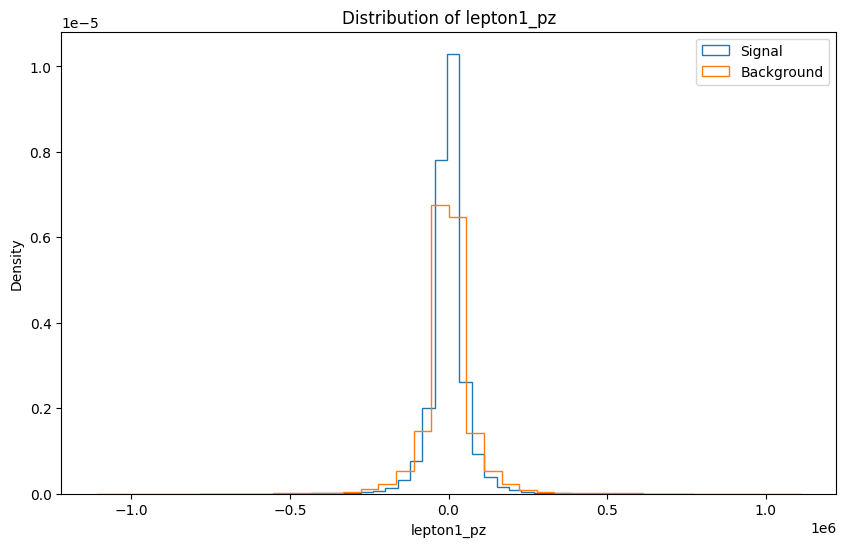

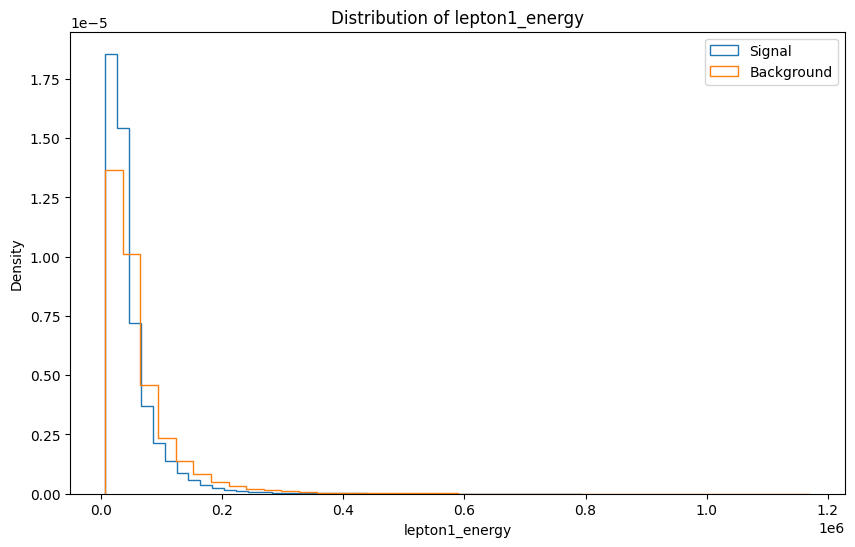

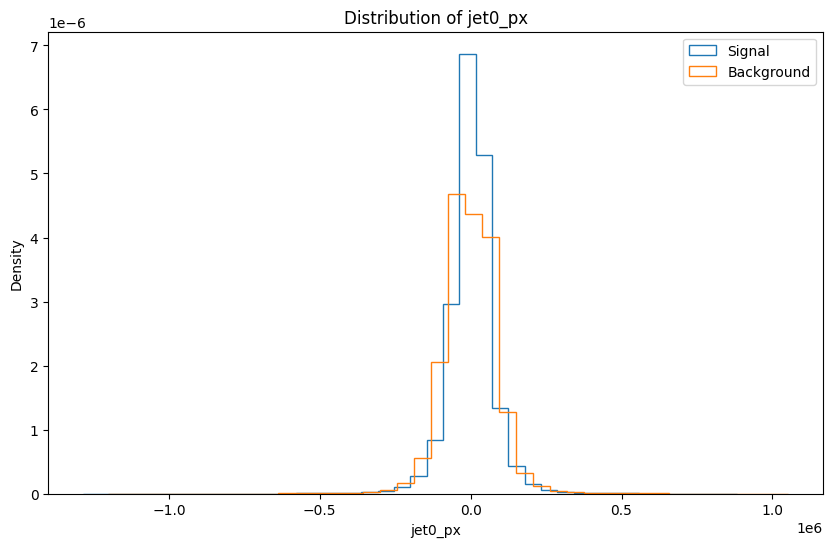

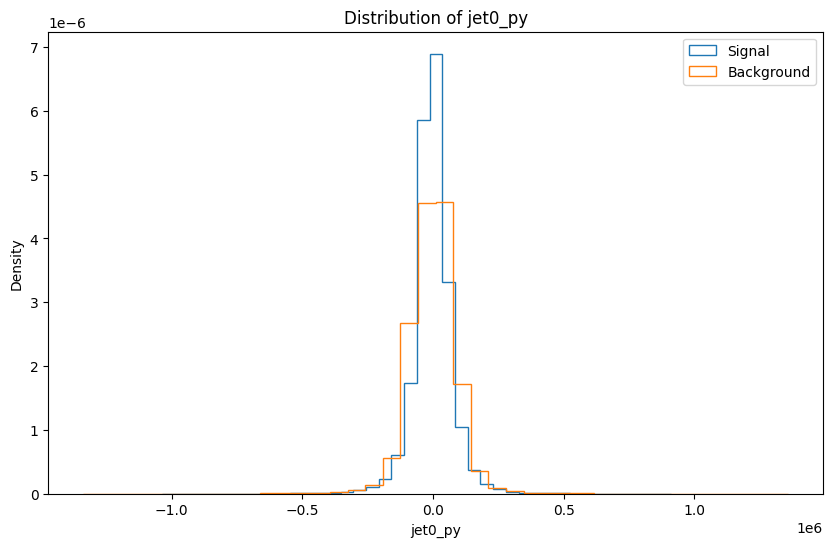

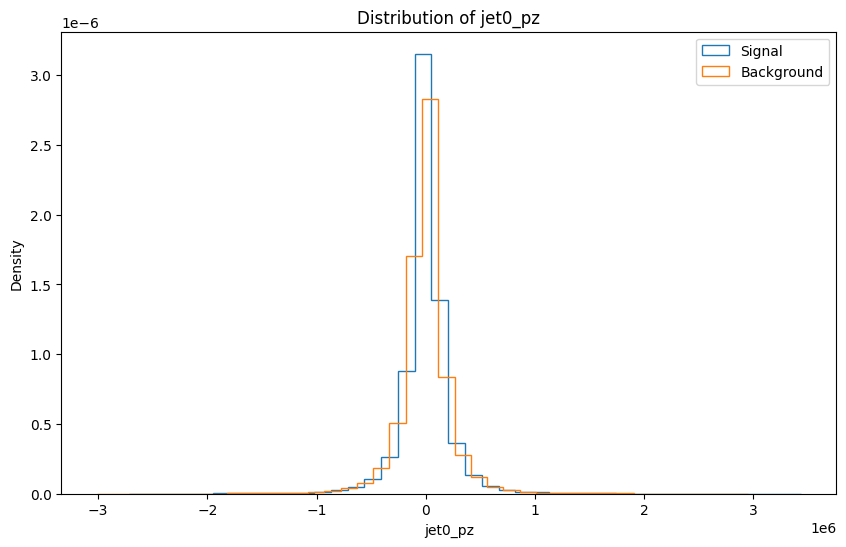

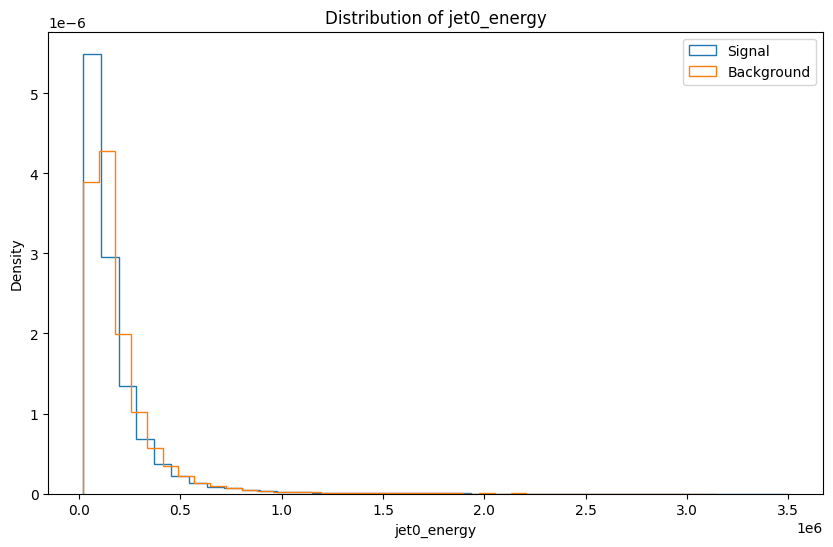

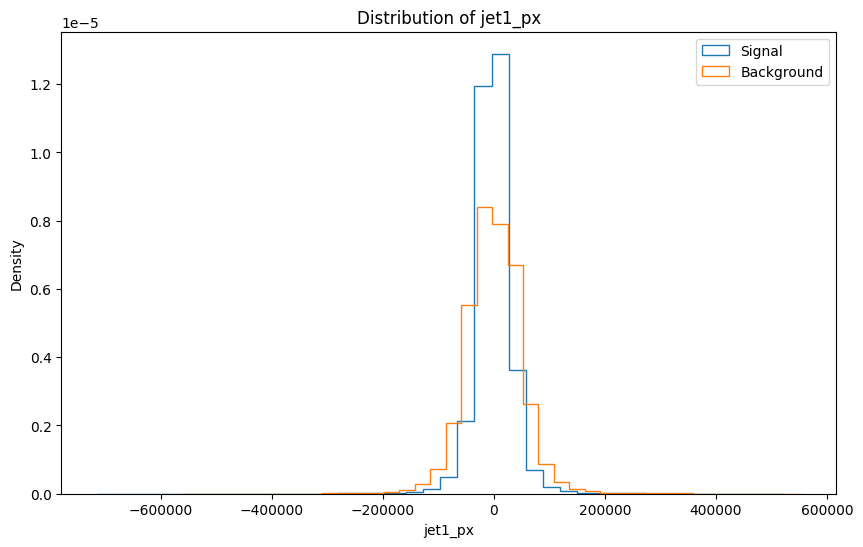

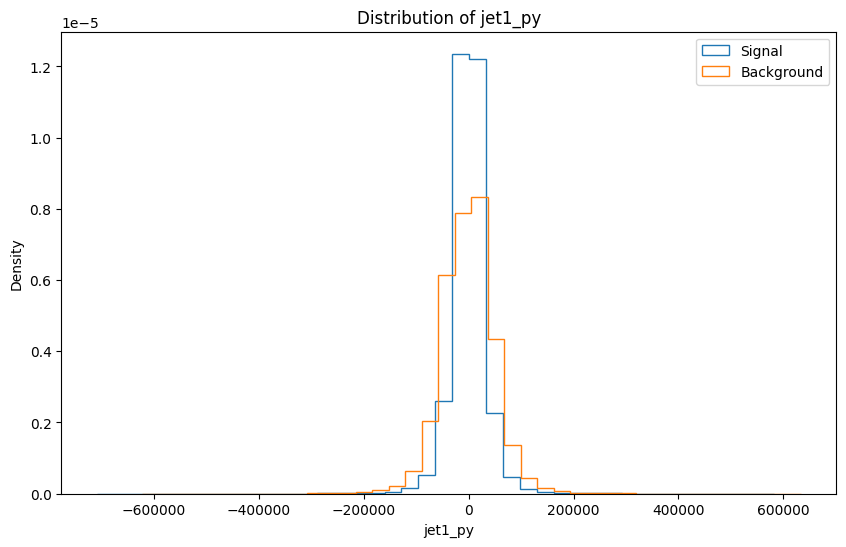

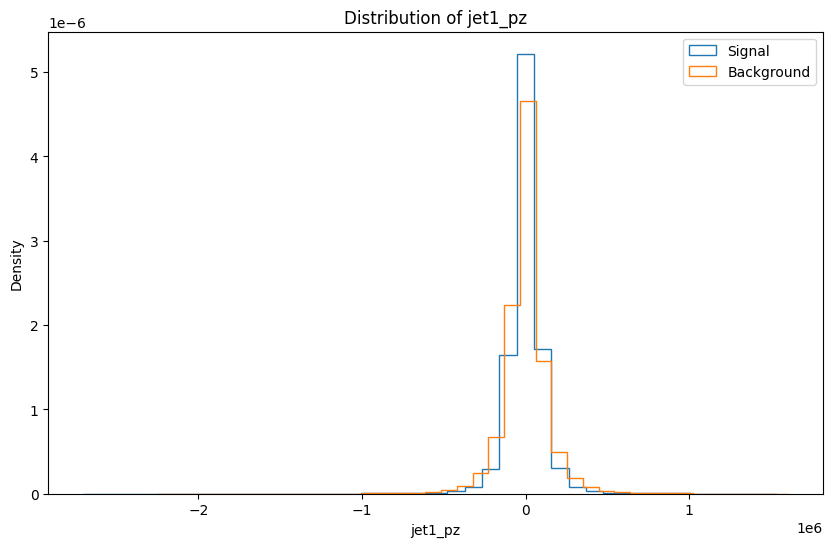

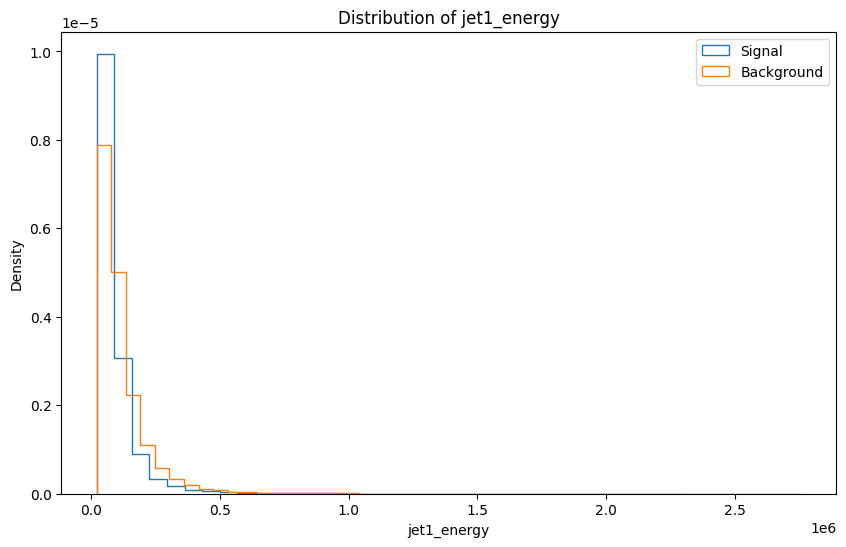

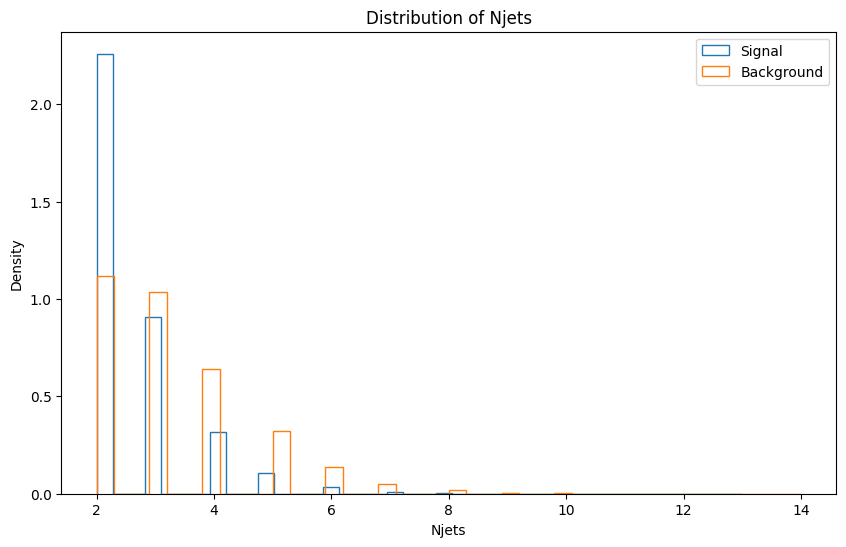

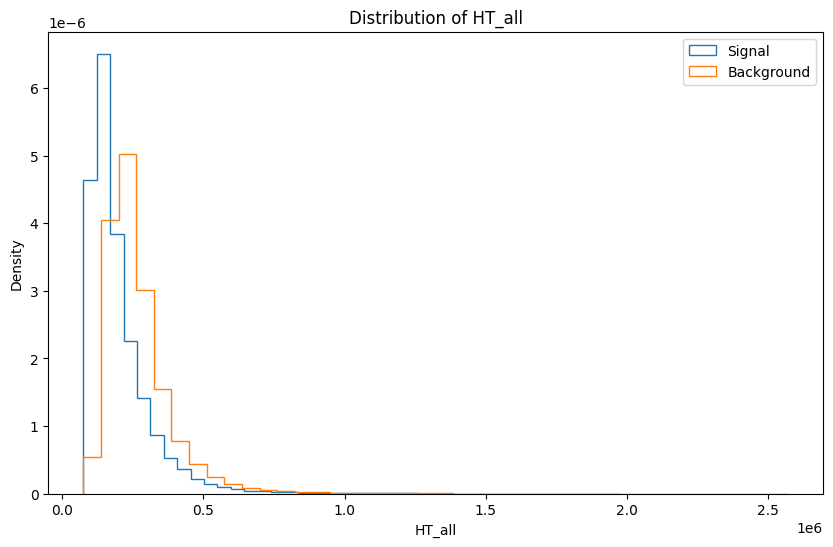

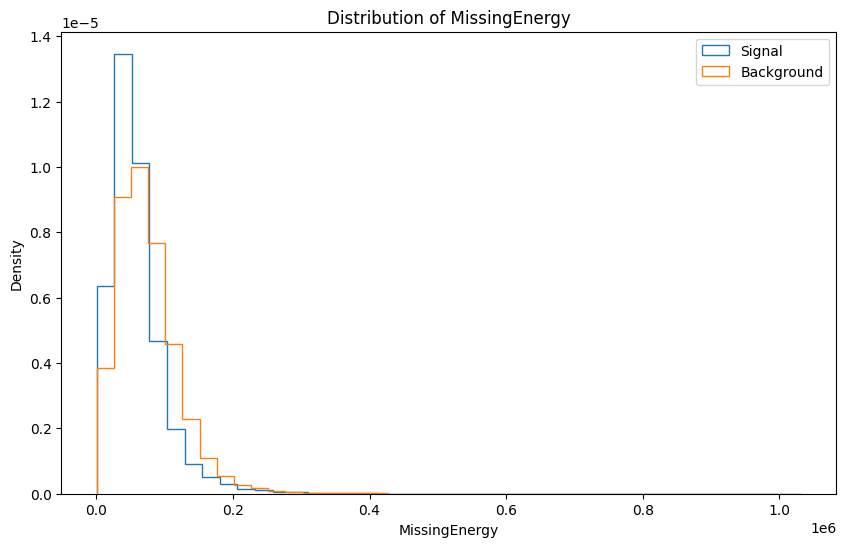

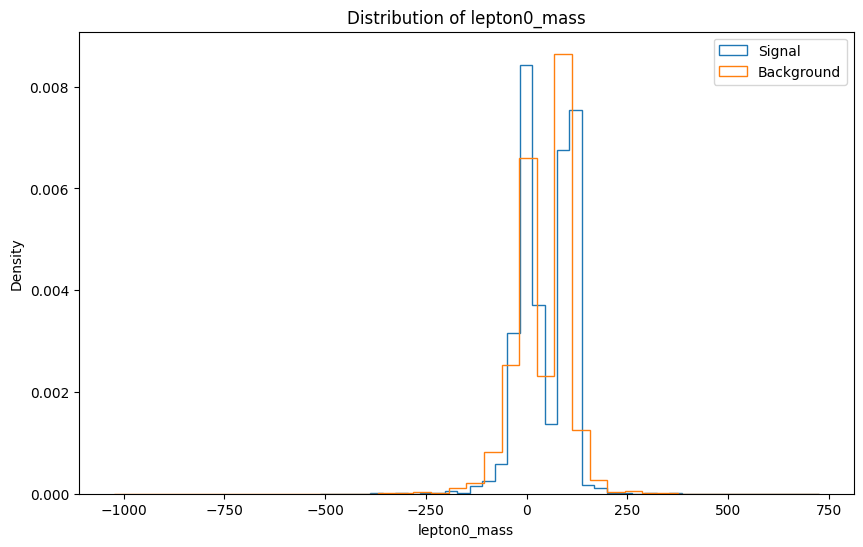

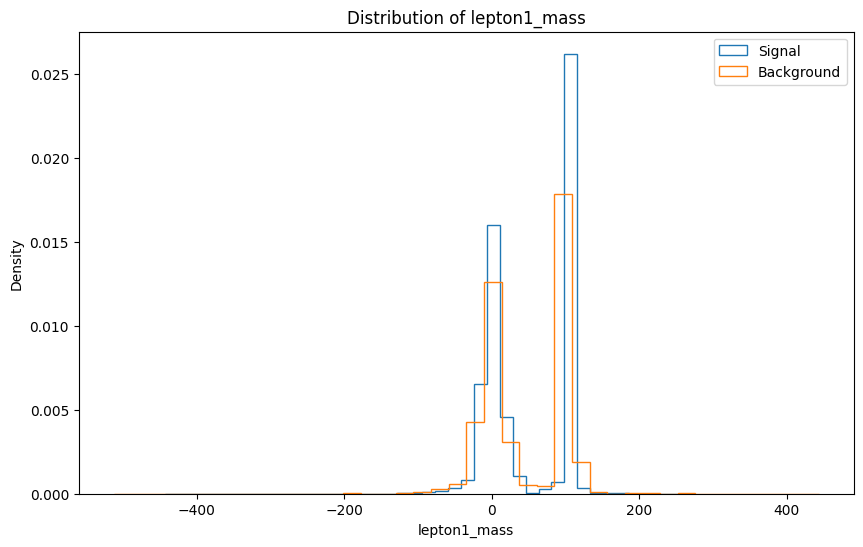

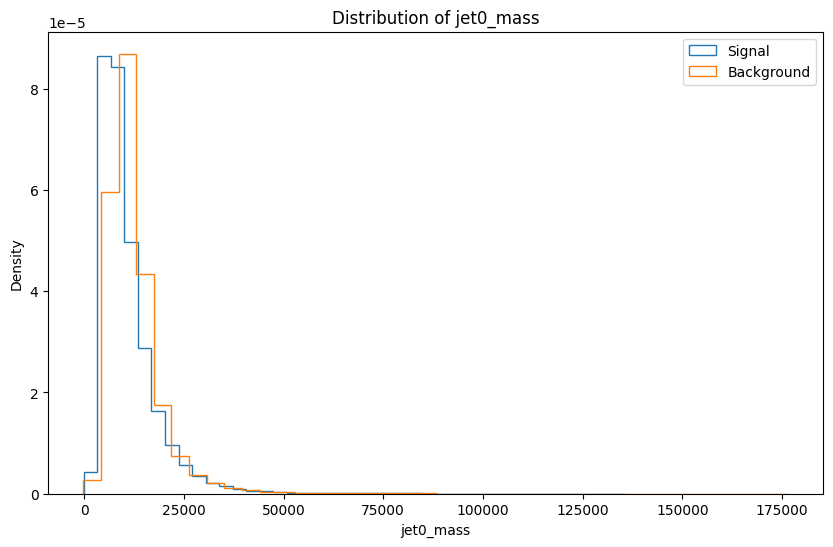

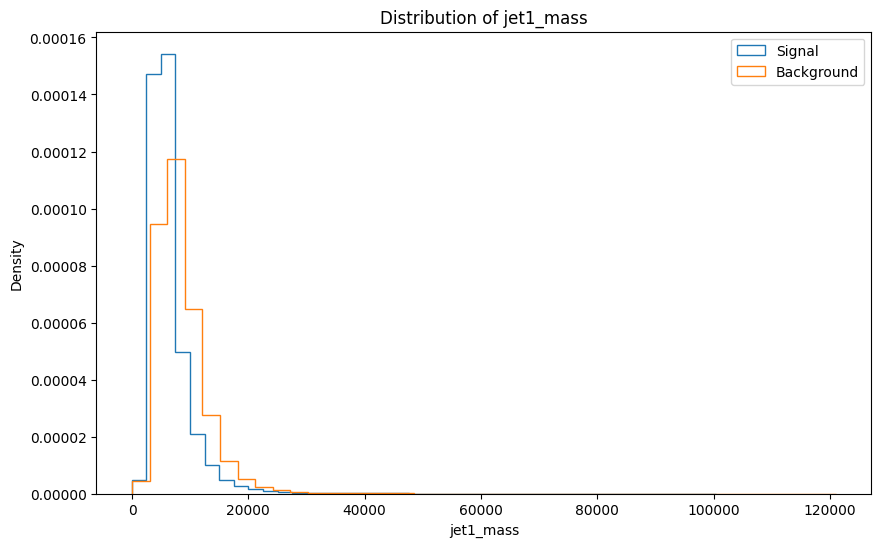

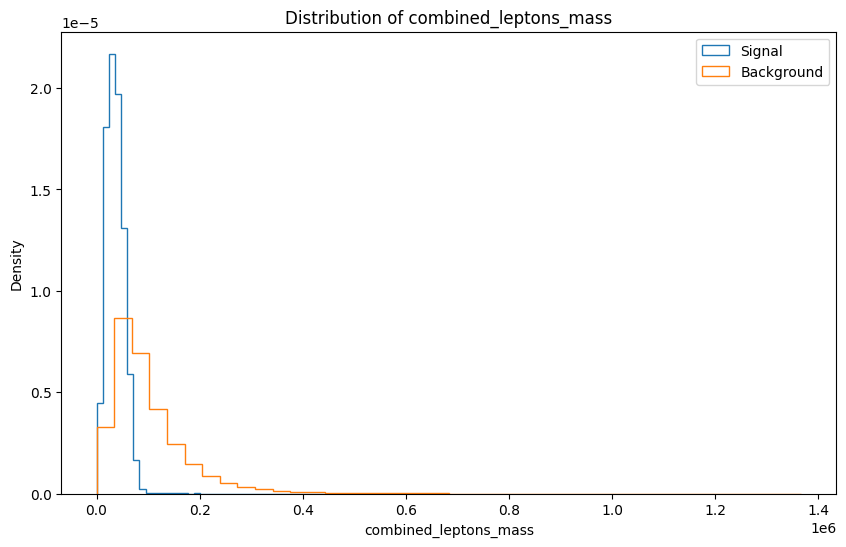

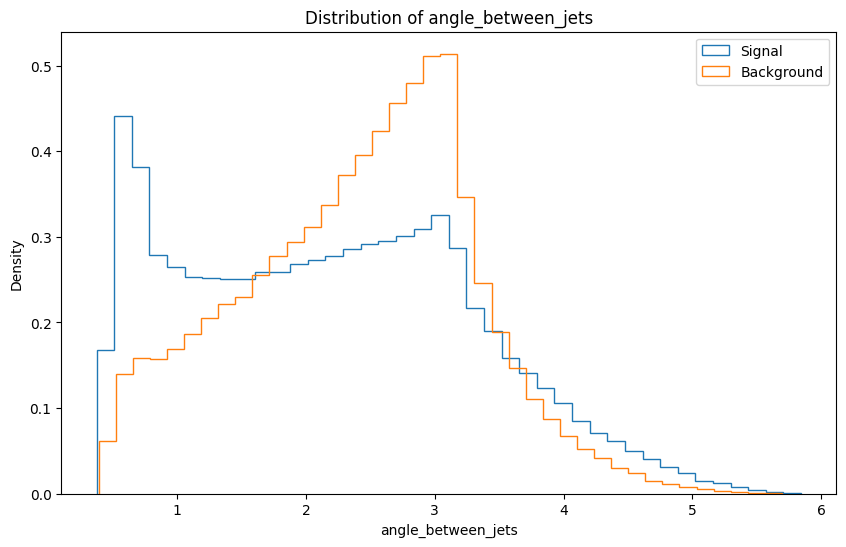

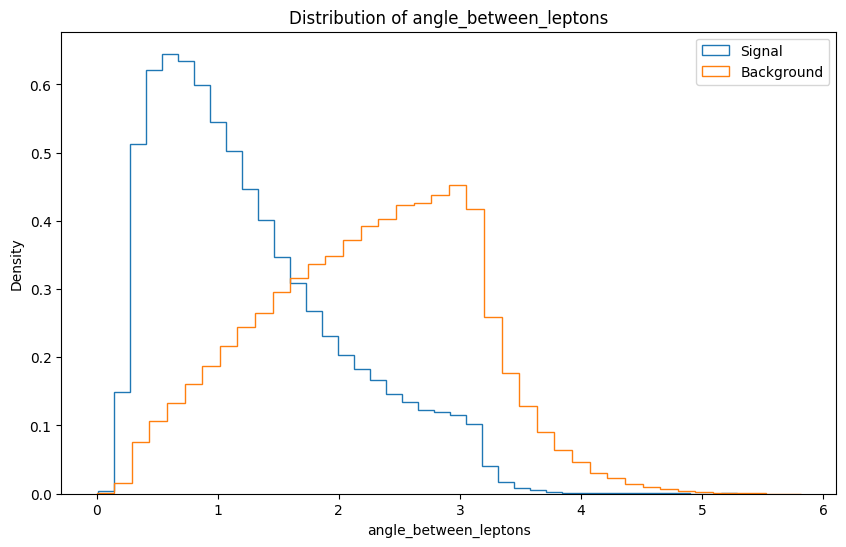

In [7]:
list_of_selected_features = df_signal.columns
for feature in list_of_selected_features:
    compare_distributions(df_signal, df_background, feature)

## Data Preparation Task

Now, since you have a feeling for the input data now, it is time to become active:

1. Create two arrays based on the `input_features` you wish to train on. We have to use the same features for signal and background.
2. Create the targets for the learning: Label 0 for background, and label 1 for signal. Hint:
3. Concatenate the signal and background input data filtered for the features you would like to use into one big `input_data` array. Do the same for the targets. Shuffle the numpy arrays. Careful: Do not shuffle before you have connected the targets to the `input_data`.
4. Split the input and target data into training, validation and testing blocks with a ratio of 80% : 10% : 10%. Hint: you can use [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
5. Normalise the data. It's good practice to just use a scaling derived on the training dataset.
6. Convert all arrays to torch.tensors.
7. Check that the tensors look sensible: correct shape, shuffled etc.

In [8]:
# define the features you are interested in
input_features = list_of_selected_features
df_signal_filtered = df_signal[input_features]
df_background_filtered = df_background[input_features]

In [9]:
# Set targets for training
y_signal     = np.ones(len(df_signal_filtered))
y_background = np.zeros(len(df_background_filtered))

In [10]:
# Combine the dataframes as one big numpy array
input_data = np.concatenate((df_signal_filtered, df_background_filtered), axis=0)
target     = np.concatenate((y_signal, y_background), axis=0)

In [11]:
# split data into train, validation, and test sets (You can also do the shuffle here, if not shuffled before)
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(input_data, target, test_size=0.2, shuffle=True)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True)

##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

You have learned that normalizing the data can lead to benefits during training. Try it out using the [`StandardScaler` from `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [37]:
# Scale the data to lie between -1 and 1 using sklearn StandardScaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

##### These are now your tensors for training

In [12]:
# As tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

## Training Task

1. Define a [`nn.Sequential` model](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). The input linear layer should be of the size `Nfeatures = len(input_features)`. Each linear layer should be succeeded by an activation function. The final activation function should be appropriate for binary classification. Hint: Something with limited value space!

2. Define a loss function and optimiser. Which loss function should we use for binary classification? There are a couple of [loss functions available in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). You can use Stochastic Gradient Descent (SGD) for now as an optimizer with a learning rate `lr=0.25`.

3. Write a training loop, inspired by the previous exercise. Make sure to track the training loss as well as the validation loss.

4. Plot the loss curve

In [13]:
# Just write this as nn.Sequential
import torch.nn as nn
N_features = len(input_features)
model = nn.Sequential(
    nn.Linear(N_features, 100),
    nn.Sigmoid(),
    nn.Linear(100, 50),
    nn.Sigmoid(),
    nn.Linear(50, 1),
    nn.Sigmoid()
)

In [14]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.25)

##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

You might have noticed that the training is not as smooth as you naively expected. Try playing around with the parameters of the SGD optimizer, e.g. the learning rate. Does this change something?

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.05)

You might also think about adding some momentum to the default SGD. Note that the [PyTorch implementation of SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) already supports two kinds of momenta.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.01)

Another option might be to use some adaptive learning. Use the [Adagrad implementation in PyTorch](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad).

In [ ]:
optimizer = optim.Adagrad(model.parameters(), lr=0.05)

Finally, try combining adaptive learning with momentum. The [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) does just that! It is the default optimizer for most ML tasks and tends to often turn out as the most optimal choice! Just use Adam from now on as a first choice.

In [1]:
optimizer = optim.Adam(model.parameters(), lr=0.05)

NameError: name 'optim' is not defined

Feel free to continue playing around with the optimizers.


#### Finally, the training loop
Following on from the syntax we had before, we can pass all our data as a torch tensor to our model. Then iterate over the training data a number of epochs until the loss converges.

We include a validation step

In [15]:
train_losses = []
val_losses   = []

N_epochs = 50

for epoch in range(N_epochs):

    model.train()
    # tell the optimizer to begin an optimization step
    optimizer.zero_grad()

    # forward pass
    # use the model as a prediction function: features → prediction
    predictions = model(X_train_tensor)

    # compute the loss (χ²) between these predictions and the intended targets
    loss = criterion(predictions, y_train_tensor.reshape(-1,1))

    # tell the loss function and optimizer to end an optimization step
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{N_epochs}], Loss: {loss.item():.4f}')

    # add in the validation loss part
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor.reshape(-1,1))
        val_losses.append(val_loss)


Epoch [1/50], Loss: 0.6962
Epoch [2/50], Loss: 0.6912
Epoch [3/50], Loss: 0.6911
Epoch [4/50], Loss: 0.6910
Epoch [5/50], Loss: 0.6909
Epoch [6/50], Loss: 0.6908
Epoch [7/50], Loss: 0.6907
Epoch [8/50], Loss: 0.6906
Epoch [9/50], Loss: 0.6905
Epoch [10/50], Loss: 0.6904
Epoch [11/50], Loss: 0.6903
Epoch [12/50], Loss: 0.6902
Epoch [13/50], Loss: 0.6901
Epoch [14/50], Loss: 0.6900
Epoch [15/50], Loss: 0.6899
Epoch [16/50], Loss: 0.6898
Epoch [17/50], Loss: 0.6897
Epoch [18/50], Loss: 0.6896
Epoch [19/50], Loss: 0.6895
Epoch [20/50], Loss: 0.6894
Epoch [21/50], Loss: 0.6893
Epoch [22/50], Loss: 0.6892
Epoch [23/50], Loss: 0.6891
Epoch [24/50], Loss: 0.6890
Epoch [25/50], Loss: 0.6889
Epoch [26/50], Loss: 0.6888
Epoch [27/50], Loss: 0.6887
Epoch [28/50], Loss: 0.6885
Epoch [29/50], Loss: 0.6884
Epoch [30/50], Loss: 0.6883
Epoch [31/50], Loss: 0.6882
Epoch [32/50], Loss: 0.6881
Epoch [33/50], Loss: 0.6880
Epoch [34/50], Loss: 0.6879
Epoch [35/50], Loss: 0.6878
Epoch [36/50], Loss: 0.6877
E

##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

You might have noticed that in each epoch you are running over the whole training dataset at once.
While this is computationally very fast, for large datasets that might become a problem, since you are loading the whole dataset into memory.
While this is not an issue in this exercise, you might keep this in mind.
More important here, an optimization in smaller increments might improve the convergence (although it is strongly tied to what learning rate you use).

Therefore, try training in mini-batches.
Here again, PyTorch makes that easy for us.
Utilize the [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) classes to create your data that can be loaded in batches.

Adjust the `batch_size` as you wish. What do you observe?

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor,
                              y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,
                              y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,
                              y_test_tensor)

# Create DataLoader objects for training, validation, and testing in batches
train_loader = DataLoader(train_dataset, batch_size=32*4096, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32*4096, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32*4096, shuffle=True)

Keep in mind, that the parameters of your model have already been pretrained in previous runs and the status is stored. If you want to reset them, meaning reinitializing the model, either rerun the cell where the model is defined, or reset the parameters using this custom function:

In [18]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

model.apply(reset_weights)

Sequential(
  (0): Linear(in_features=26, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=50, out_features=1, bias=True)
  (5): Sigmoid()
)

Next, adjust your training loop to run over the batches of data.

In [ ]:
# Training loop on mini-batches with loss stored for plotting
train_losses = []
val_losses = []
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    # run over batches of data
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # compute avergae loss over all batches
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/40, Train Loss: 0.6599, Val Loss: 0.6587
Epoch 2/40, Train Loss: 0.6579, Val Loss: 0.6561
Epoch 3/40, Train Loss: 0.6552, Val Loss: 0.6539
Epoch 4/40, Train Loss: 0.6532, Val Loss: 0.6519
Epoch 5/40, Train Loss: 0.6511, Val Loss: 0.6516
Epoch 6/40, Train Loss: 0.6506, Val Loss: 0.6482
Epoch 7/40, Train Loss: 0.6470, Val Loss: 0.6456
Epoch 8/40, Train Loss: 0.6443, Val Loss: 0.6425
Epoch 9/40, Train Loss: 0.6422, Val Loss: 0.6409
Epoch 10/40, Train Loss: 0.6394, Val Loss: 0.6384
Epoch 11/40, Train Loss: 0.6375, Val Loss: 0.6363
Epoch 12/40, Train Loss: 0.6353, Val Loss: 0.6349
Epoch 13/40, Train Loss: 0.6337, Val Loss: 0.6318
Epoch 14/40, Train Loss: 0.6306, Val Loss: 0.6300
Epoch 15/40, Train Loss: 0.6275, Val Loss: 0.6294
Epoch 16/40, Train Loss: 0.6265, Val Loss: 0.6246
Epoch 17/40, Train Loss: 0.6223, Val Loss: 0.6245
Epoch 18/40, Train Loss: 0.6225, Val Loss: 0.6272
Epoch 19/40, Train Loss: 0.6239, Val Loss: 0.6240
Epoch 20/40, Train Loss: 0.6219, Val Loss: 0.6300
Epoch 21/

#### Now let's have a look at the loss function

Plot the loss values you obtained for both the training and validation data over the training epochs.

What do you observe? Did the training converge?

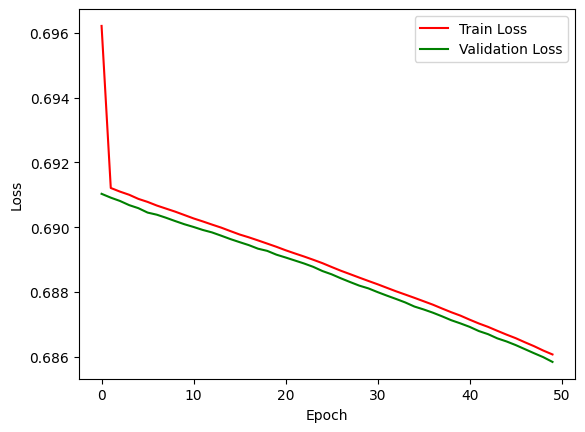

In [19]:
# Plot loss function for training and validation sets
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss', color='red')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])

##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

You might observe that your training hasn't converged yet, and you need to increase the number of training epochs.

It might also be that your model did converge, but you observe serious overtraining by comparing the training with the validation loss.

Or your convergence is just fine, and you don't see overtraining, but your model performance sucks.

In any case, try to improve your model training by what you have learned in the lecture. The red sections should provide you with some guidance, but feel free to add whatever you consider appropriate. Have fun!

## Evaluate Model Performance

So, how does our model perform? The losses only tell us that the model learns something. But it is unclear how well it does.

We need to evaluate this on an idependent dataset. Luckily, you have prepared an independent test dataset above!

1. Evaluate the model on the testing dataset.
3. Plot the distribution of scores, for each, true Signal and Background classes.
4. Compute various metrics
5. Plot ROC curve (example code given)

In [40]:
# Evaluate the model on the test dataset
# per default  PyTorch will add the predicted values to the computation graph
# Call the detach() method to remove them
y_pred = model(X_test_tensor).detach()

In [41]:
# Filter the predicted events for true Signal and true Background
true_signal = y_pred[y_test==1].numpy()
true_bkg = y_pred[y_test==0].numpy()

(0.0, 1.0)

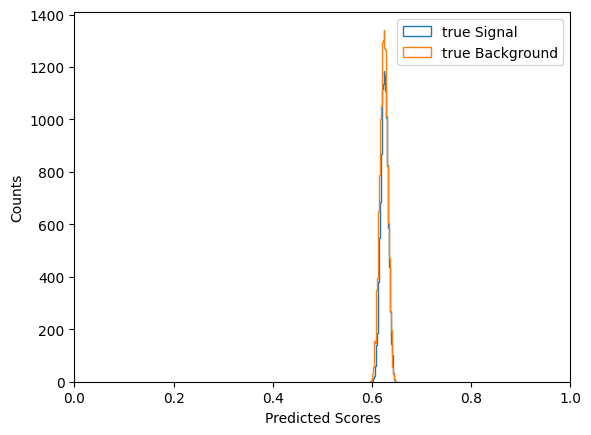

In [46]:
# Plot the predicted scores for both true Signal and true Background events
import matplotlib.pyplot as plt
plt.hist(true_signal, bins=40, histtype='step', label='Signal', density=False)
plt.hist(true_bkg, bins=40, histtype='step', label='Background', density=False)
plt.legend(["true Signal","true Background"])
plt.xlabel("Predicted Scores")
plt.ylabel("Counts")
plt.xlim((0,1))

#### Question!

From this visual help: Was your model able to distinguish Signal from Background?

#### Quantify how well your model did

Let's now compute the accuracy and some other metrics that quantify how well your model distinguished between Signal and Background.

Use the implementations for the metrics from [`sklearn.metrics`](https://scikit-learn.org/stable/api/sklearn.metrics.html).

In [47]:
# sklearn.metrics require exact value matches, so we need to round to 0 or 1
final_prediction_score =y_pred.numpy()
final_prediction = np.round(final_prediction_score)

In [48]:
# Compute the accuracy_score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, final_prediction)
print(accuracy)


0.47217814450439016


In [49]:
# Caclulate some other metrics that are suitable for a classification
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_test, final_prediction, average='weighted')
recall = recall_score(y_test, final_prediction, average='weighted')
f1 = f1_score(y_test, final_prediction, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.22295220014760872
Recall: 0.47217814450439016
F1 Score: 0.30288752890386883


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### The Receiver Operating Characteristic (ROC) curve

A common method in order to quantify how well a classifier performs is to look on the rate of false positives and true positive classifications.
The so-called Receiver Operating Characteristic (ROC) combines these into a single visual representation by plotting the two values in a 2D scatter.

However, with our NN model we have trained above, we can create an almost infinite number of classifiers (restricted only by the numerical precision), by varying the `Predicted Score` value at which we define the border between Signal and Background.

This gives us a quasi-continuous set of points in the aforementioned 2D scatter, a curve. We call this the ROC curve.
This is a common visual tool for comparing different classifier models, but we can also derive a quantifyable number related to this by computing the integral under this curve. Since it is measuring the **a**rea **u**nder the **c**urve, we call it ROC-AUC.

Again, we can use the implementations from sklearn.metrics for the `roc_curve` and also to compute the `auc`.

Plot the ROC curve and compute the ROC-AUC!

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,final_prediction_score)

np.float64(0.5689398111299777)

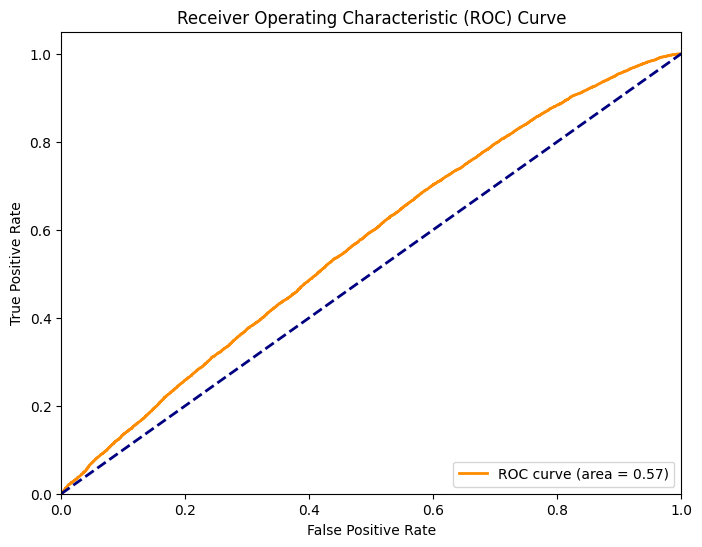

In [51]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, final_prediction_score)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Question!

How does your classifier perform in comparison to a random classification that assigns randomly 0 or 1 to an event with equal probability?

### Bonuses
1. Study the feature importance of your model

In [29]:
# Compute feature importance of 26 input features to DNN
import numpy as np
from sklearn.metrics import accuracy_score

def permutation_importance(model, X_val_tensor, y_val):

    detach_to_binary = lambda x: np.round(model(x).detach().numpy())

    baseline_score = accuracy_score(y_val, detach_to_binary(X_val_tensor))  # For a classification task
    importances = []

    for feature_idx in range(X_val_tensor.shape[1]):
        # Shuffle the values of the current feature
        X_val_shuffled = X_val_tensor.clone()
        X_val_shuffled[:, feature_idx] = X_val_shuffled[:, feature_idx][torch.randperm(X_val.shape[0])]

        # Recalculate the performance
        score_shuffled = accuracy_score(y_val, detach_to_binary(X_val_shuffled))
        print(score_shuffled)

        # The difference in performance is the importance of this feature
        importances.append(baseline_score - score_shuffled)

    return np.array(importances)

# Usage example
importances = permutation_importance(model, X_val_tensor, y_val_tensor)


0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425
0.46921612186607425


In [30]:
idx = np.argsort(np.asarray(importances))

In [31]:
df_background.columns.to_numpy()[:23]

array(['lepton0_px', 'lepton0_py', 'lepton0_pz', 'lepton0_energy',
       'lepton1_px', 'lepton1_py', 'lepton1_pz', 'lepton1_energy',
       'jet0_px', 'jet0_py', 'jet0_pz', 'jet0_energy', 'jet1_px',
       'jet1_py', 'jet1_pz', 'jet1_energy', 'Njets', 'HT_all',
       'MissingEnergy', 'lepton0_mass', 'lepton1_mass', 'jet0_mass',
       'jet1_mass'], dtype=object)

In [32]:
sorted_features_descending = df_background.columns.to_numpy()[idx]

for i in range(len(sorted_features_descending)):
    print(f"Feature: {sorted_features_descending[i]}, Importance: {importances[idx[i]]:.4f}")

Feature: lepton0_px, Importance: 0.0000
Feature: lepton0_py, Importance: 0.0000
Feature: lepton0_pz, Importance: 0.0000
Feature: lepton0_energy, Importance: 0.0000
Feature: lepton1_px, Importance: 0.0000
Feature: lepton1_py, Importance: 0.0000
Feature: lepton1_pz, Importance: 0.0000
Feature: lepton1_energy, Importance: 0.0000
Feature: jet0_px, Importance: 0.0000
Feature: jet0_py, Importance: 0.0000
Feature: jet0_pz, Importance: 0.0000
Feature: jet0_energy, Importance: 0.0000
Feature: jet1_px, Importance: 0.0000
Feature: jet1_py, Importance: 0.0000
Feature: jet1_pz, Importance: 0.0000
Feature: jet1_energy, Importance: 0.0000
Feature: Njets, Importance: 0.0000
Feature: HT_all, Importance: 0.0000
Feature: MissingEnergy, Importance: 0.0000
Feature: lepton0_mass, Importance: 0.0000
Feature: lepton1_mass, Importance: 0.0000
Feature: jet0_mass, Importance: 0.0000
Feature: jet1_mass, Importance: 0.0000
Feature: combined_leptons_mass, Importance: 0.0000
Feature: angle_between_jets, Importance: 

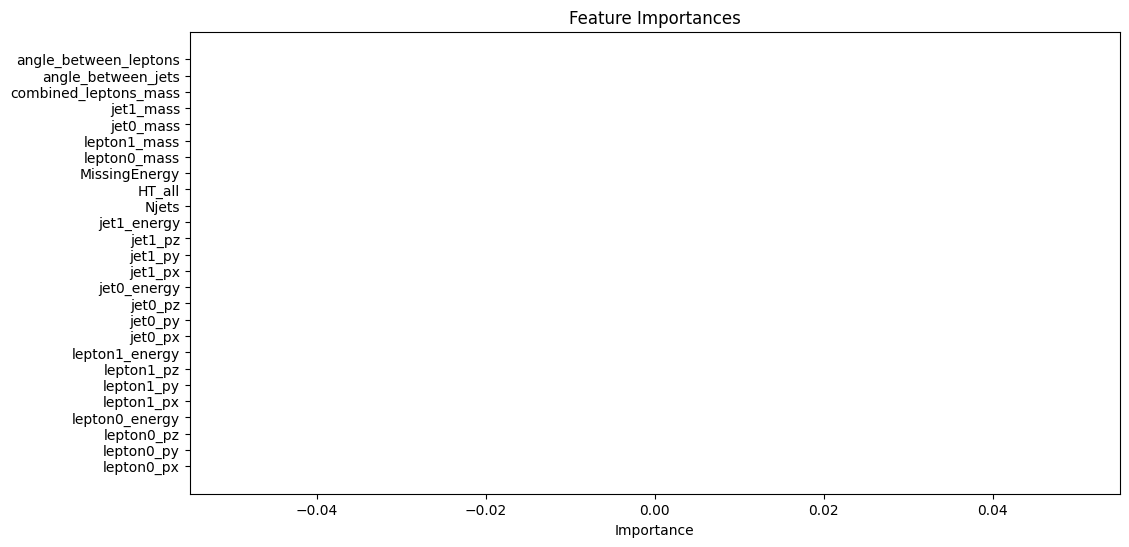

In [33]:
# Plot feature importances
import matplotlib.pyplot as plt
importances = importances[idx]
plt.figure(figsize=(12, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), sorted_features_descending)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()